Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
g:\Meine Ablage\Universität\Master Thesis\Multi-Classification\training\libraries_multilabel\MultiLabelExplanationWrapper.py:43: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


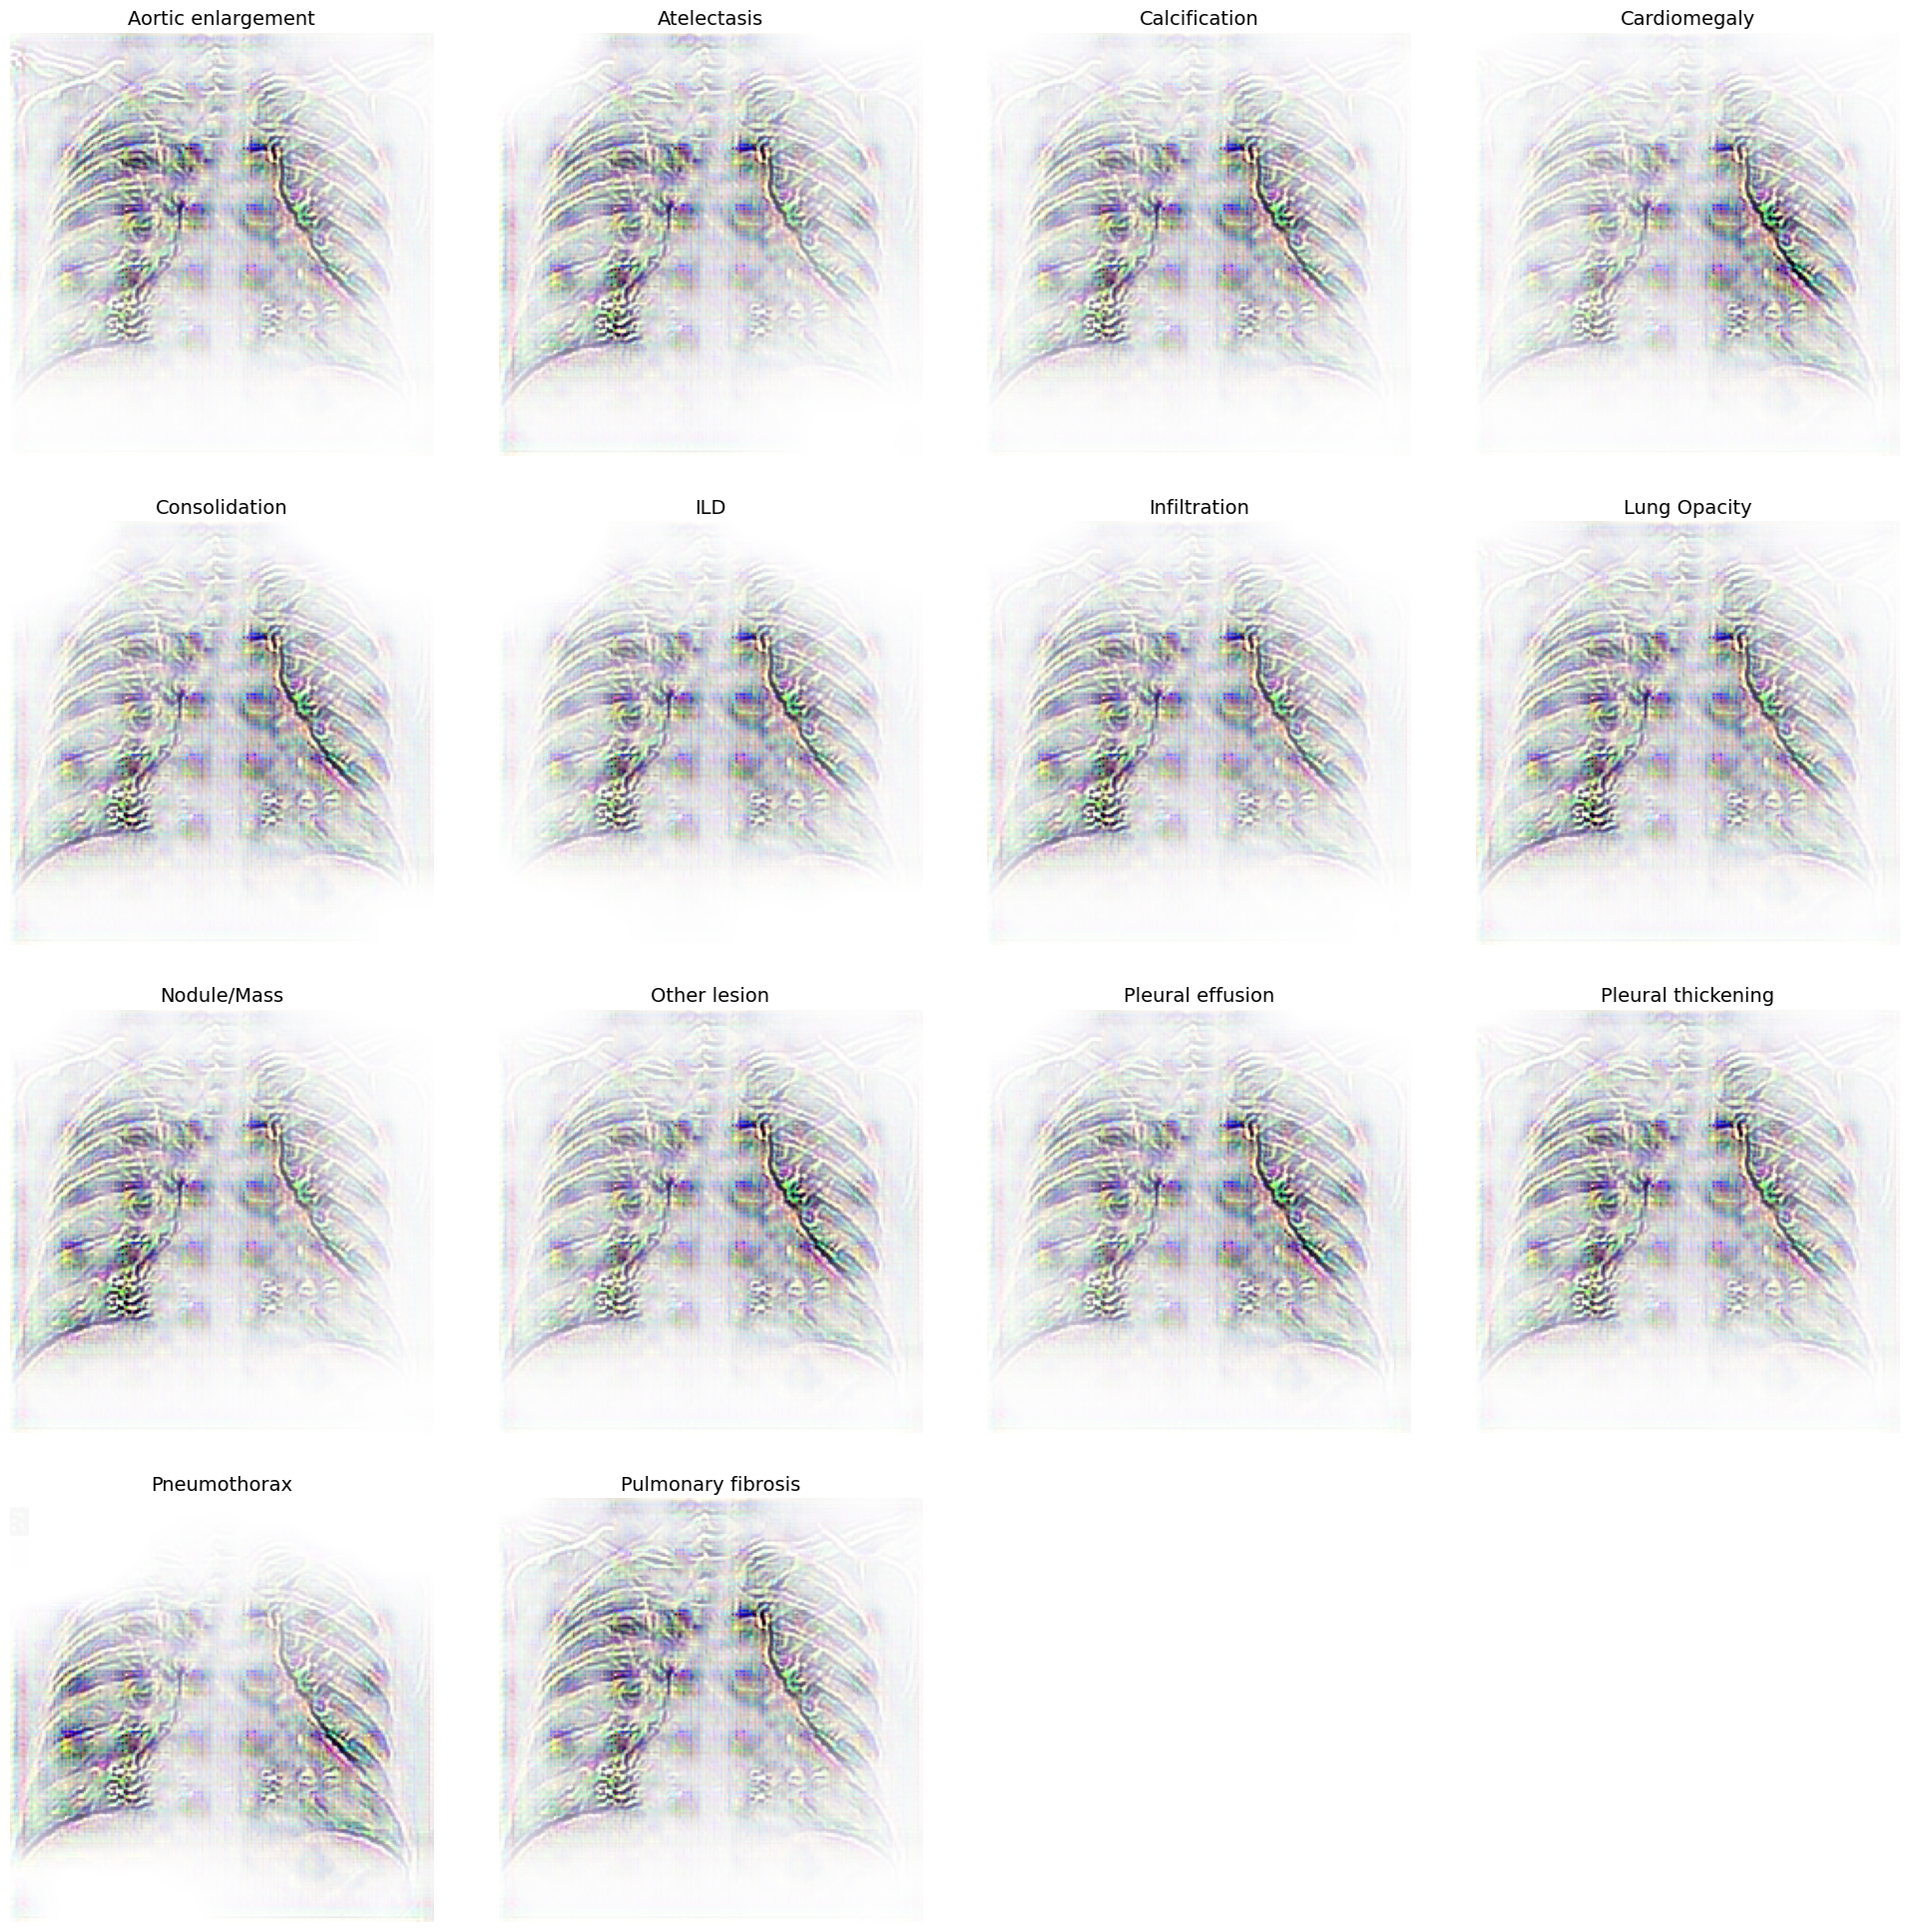

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image
import random
import matplotlib.pyplot as plt
import warnings
from typing import Dict, Any
from libraries_multilabel.bcosconv2d import NormedConv2d
from bcos.common import BcosUtilMixin
from libraries_multilabel.MultiLabelExplanationWrapper import CustomModelWrapper

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
#model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos_Blur\light_oversamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
#model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos_FLC\no_nosamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos\no_nosamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()

class_names = ["Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity",
    "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
    "Pneumothorax", "Pulmonary fibrosis"]



    
# Load the pretrained model
pretrained_model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
pretrained_model.fc.linear = NormedConv2d(2048, 14, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
#pretrained_model.layer2[0].conv2 = ModifiedBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
#pretrained_model.layer2[0].downsample[0] = ModifiedBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2)

#pretrained_model.layer3[0].conv2 = ModifiedBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
#pretrained_model.layer3[0].downsample[0] = ModifiedBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2)

#pretrained_model.layer4[0].conv2 = ModifiedBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
#pretrained_model.layer4[0].downsample[0] = ModifiedBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2)

#pretrained_model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

#pretrained_model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

#pretrained_model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)    

state_dict_better = torch.load(model_path_better)
pretrained_model.load_state_dict(state_dict_better)
pretrained_model.eval()
pretrained_model.to(device)
custom_wrapper = CustomModelWrapper(pretrained_model)

# Load your image

#image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\0a380c45055b031c116507bdc5acff33.png"
#image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\2b3f933dae2d8beb2f065fd3a7bded78.png" 
image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\9a5094b2563a1ef3ff50dc5c7ff71345.png" 

image = Image.open(image_path).convert("RGB")
tensor_image = TF.to_tensor(image)
numpy_image = (tensor_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
pil_image = Image.fromarray(numpy_image)

transformed_image = pretrained_model.transform(pil_image)
transformed_image = transformed_image[None].to(device)

expl = custom_wrapper.explain(in_tensor=transformed_image, explain_all_classes=True)
explanations = expl["explanations"]

num_classes = len(explanations)
cols = 4
rows = (num_classes + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Large figure for clarity
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for idx, (class_name, explanation) in enumerate(explanations.items()):
    ax = axes[idx]
    im = ax.imshow(explanation, cmap='viridis')
    ax.set_title(f"{class_names[idx]}", fontsize=14)
    ax.axis('off')

for idx in range(len(explanations), len(axes)):
    axes[idx].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(pad=3.0)
plt.show()



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
g:\Meine Ablage\Universität\Master Thesis\Multi-Classification\training\libraries_multilabel\MultiLabelExplanationWrapper.py:43: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Predicted classes: ['Aortic enlargement', 'Calcification', 'Pleural thickening']
Found 2 bounding boxes for predicted classes


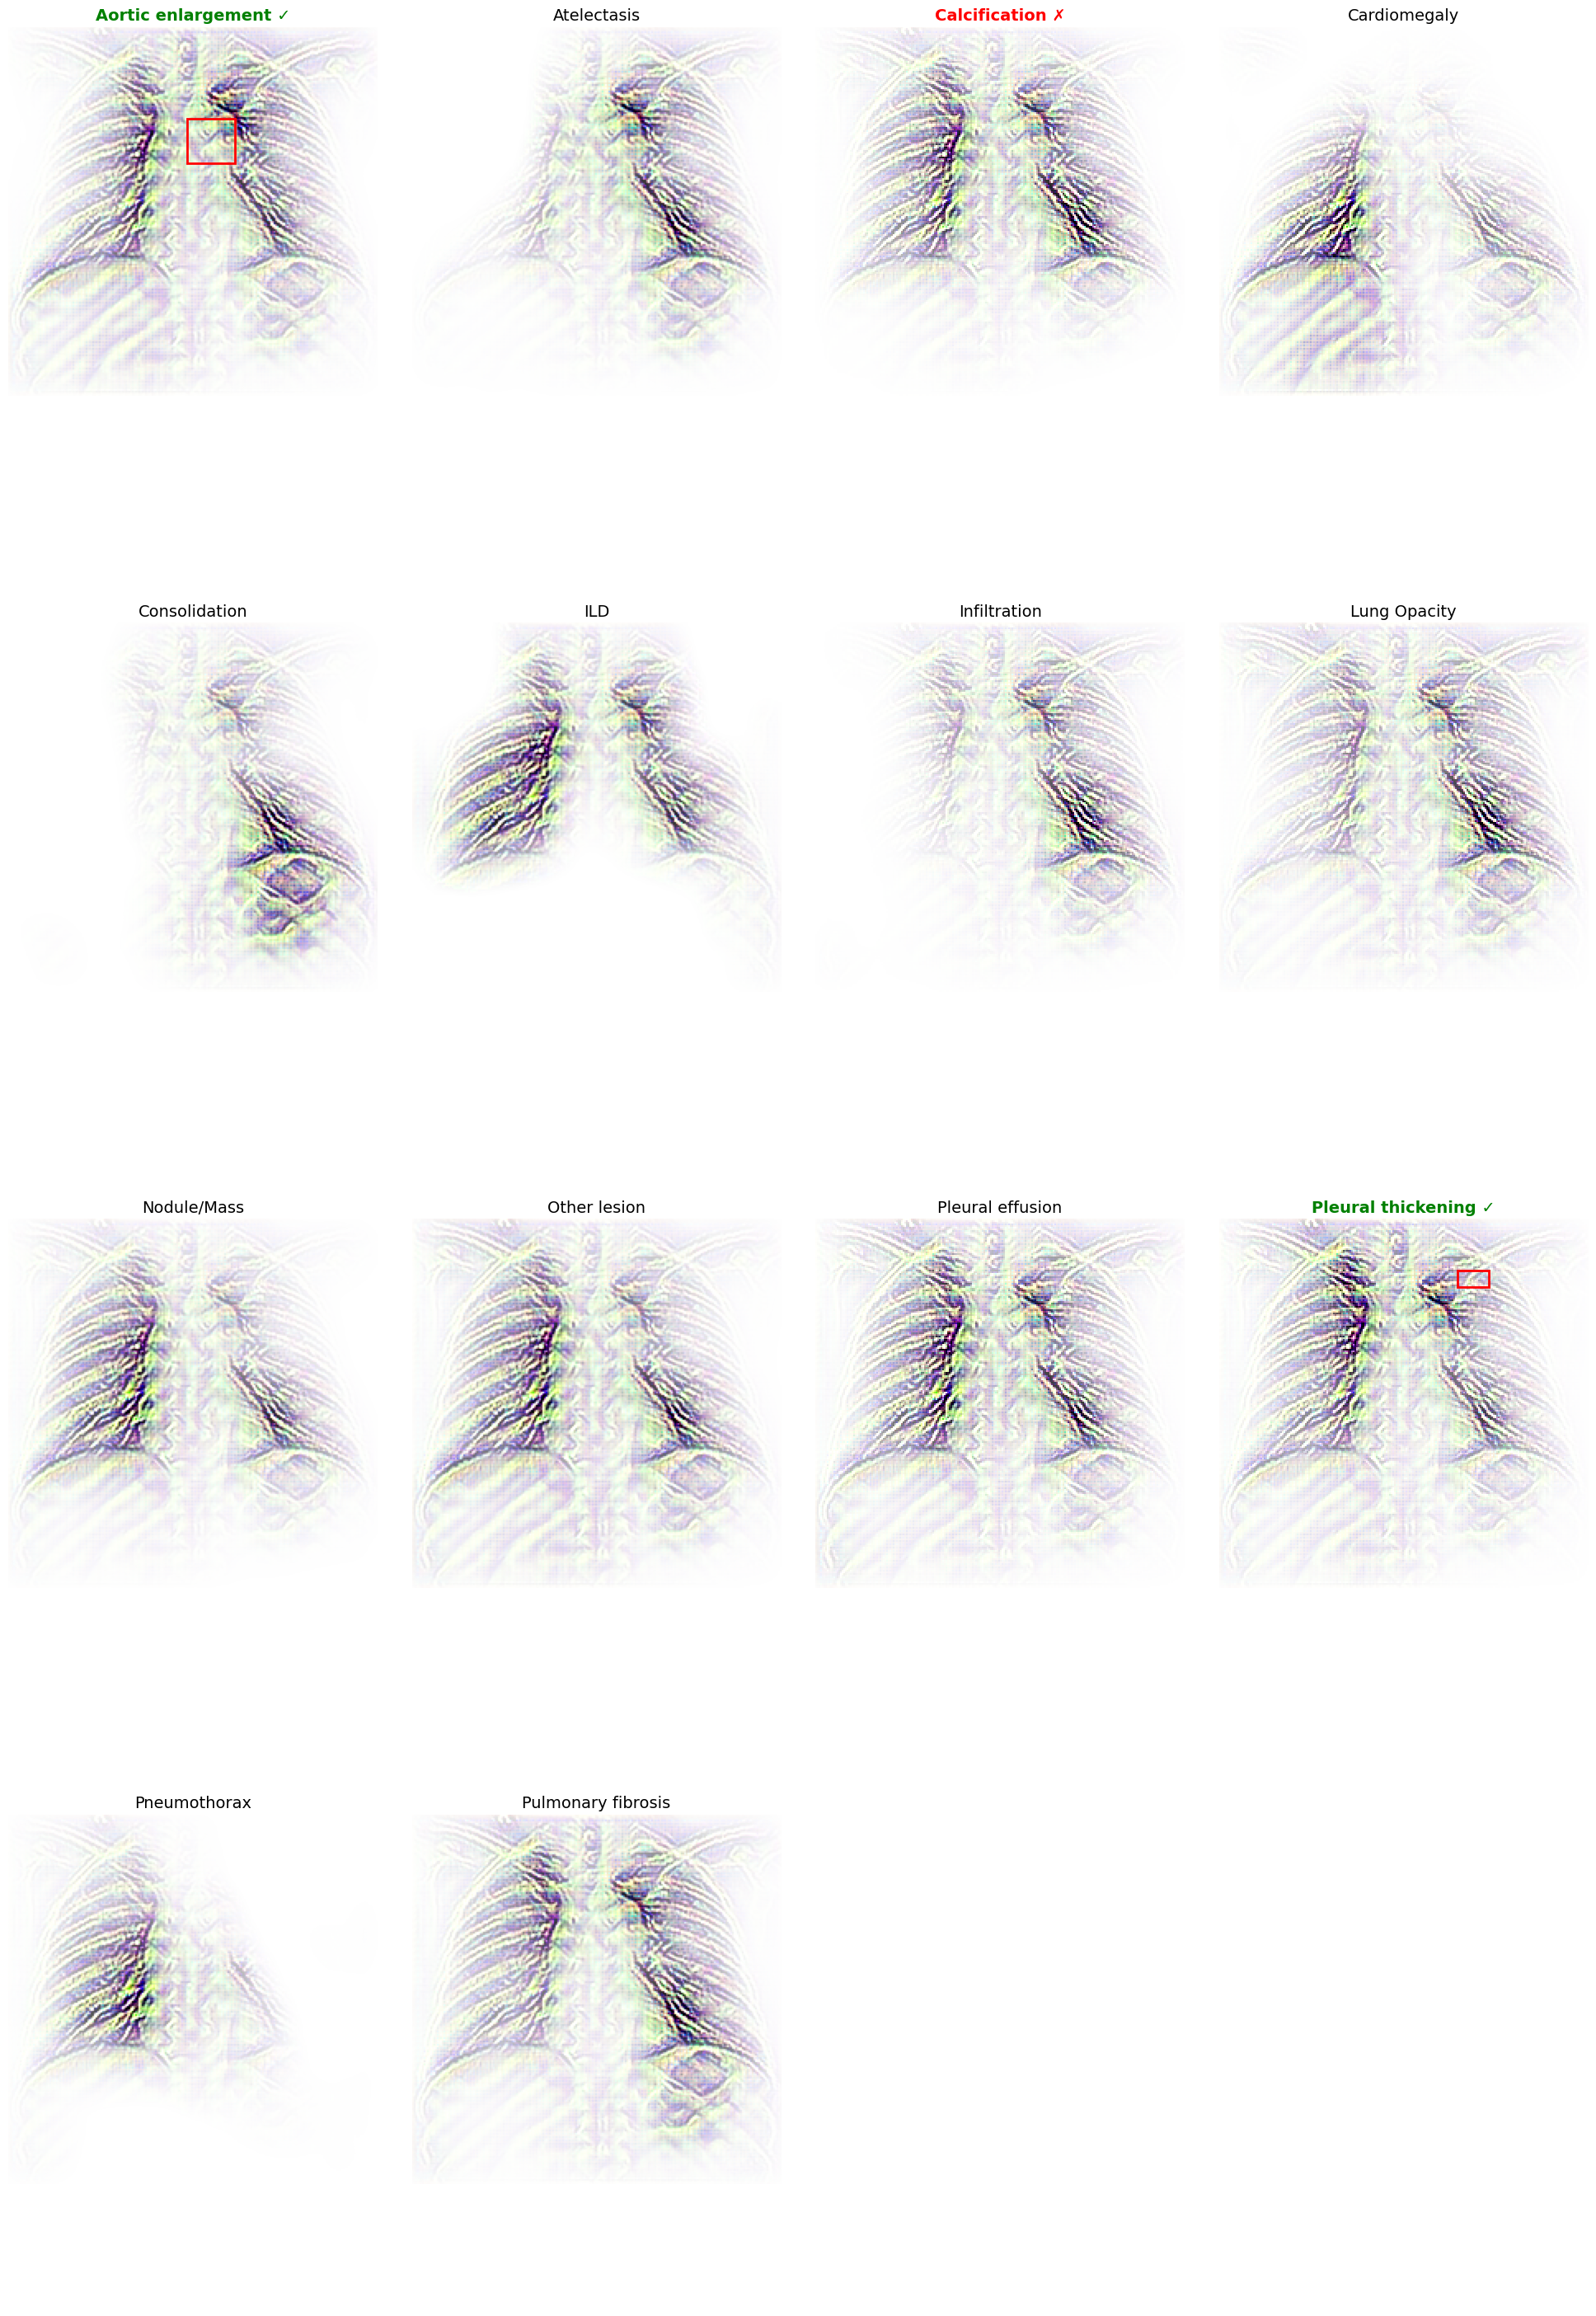

Probabilities: tensor([[0.6303, 0.0021, 0.7562, 0.0038, 0.0024, 0.0012, 0.0298, 0.0805, 0.4668,
         0.1416, 0.0365, 0.5285, 0.0014, 0.0827]])
Binary Predictions: tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=torch.int32)


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
import random
import matplotlib.pyplot as plt
from libraries_multilabel.bcosconv2d import NormedConv2d
from libraries_multilabel.MultiLabelExplanationWrapper import CustomModelWrapper
from pooling.blur_bcosconv2d import ModifiedBcosConv2d

from torchvision.models.resnet import ResNet
''

bbox_df = pd.read_csv(r"D:\vinbigdata-chest-xray-abnormalities-detection\train224.csv")
multi_df = pd.read_csv(r"D:\vinbigdata-chest-xray-abnormalities-detection\multilabel_dataset.csv")


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
#model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos_Blur\light_oversamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
#model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos_FLC\no_nosamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"
model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos_Blur\light_oversamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()

class_names = ["Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity",
    "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
    "Pneumothorax", "Pulmonary fibrosis"]

    
# Load the pretrained model
pretrained_model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
pretrained_model.fc.linear = NormedConv2d(2048, 14, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

pretrained_model.layer2[0].conv2 = ModifiedBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
pretrained_model.layer2[0].downsample[0] = ModifiedBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2)

pretrained_model.layer3[0].conv2 = ModifiedBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
pretrained_model.layer3[0].downsample[0] = ModifiedBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2)

pretrained_model.layer4[0].conv2 = ModifiedBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2)
pretrained_model.layer4[0].downsample[0] = ModifiedBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2)

#pretrained_model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

#pretrained_model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

#pretrained_model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
#pretrained_model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)    

state_dict_better = torch.load(model_path_better)
pretrained_model.load_state_dict(state_dict_better)
pretrained_model.eval()
pretrained_model.to(device)
custom_wrapper = CustomModelWrapper(pretrained_model)

#image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\fef3e36fbec340a6ef785936fb8859c6.png" #- three differnet diseases
#image_id = "fef3e36fbec340a6ef785936fb8859c6"

image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\fe712042bd989a581a931a300fee1203.png" #- three differnet diseases
image_id = "fe712042bd989a581a931a300fee1203"





image_bboxes = bbox_df[bbox_df["image_id"] == image_id]
first_bboxes = image_bboxes.groupby("class_name", as_index=False).first()

image = Image.open(image_path).convert("RGB")
tensor_image = TF.to_tensor(image)
numpy_image = (tensor_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
pil_image = Image.fromarray(numpy_image)

transformed_image = pretrained_model.transform(pil_image)
transformed_image = transformed_image[None].to(device)

expl = custom_wrapper.explain(in_tensor=transformed_image, explain_all_classes=True)
explanations = expl["explanations"] 

import matplotlib.patches as patches

num_classes = len(explanations)
cols = 4  # Changed from 7 to 3
rows = (num_classes + cols - 1) // cols

# Create a figure with larger dimensions and better layout
fig, axes = plt.subplots(rows, cols, figsize=(20, 30))  # Wider and taller
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]  # Handle single subplot case

preds = expl["binary_predictions"][0].numpy()  # [0,1,0,...] for 14 classes
predicted_classes = [class_names[i] for i, p in enumerate(preds) if p == 1]

# Load bounding box data and get image_id
bbox_df = pd.read_csv(r"D:\vinbigdata-chest-xray-abnormalities-detection\train224.csv")

# Filter bounding boxes for this image and predicted classes only
bbox_rows = bbox_df[(bbox_df["image_id"] == image_id) & (bbox_df["class_name"].isin(predicted_classes))]
# Get first bounding box per predicted class
first_bboxes = bbox_rows.groupby("class_name", as_index=False).first()

print(f"Predicted classes: {predicted_classes}")
print(f"Found {len(first_bboxes)} bounding boxes for predicted classes")

# Loop through each class and plot its explanation
ground_truth_labels = multi_df[multi_df["image_id"] == image_id]

for idx, (class_name, explanation) in enumerate(explanations.items()):
    if idx < len(axes):
        ax = axes[idx]
        im = ax.imshow(explanation, cmap='viridis')

        current_class_name = class_names[idx]
        is_predicted = current_class_name in predicted_classes
        is_correct = False
        is_false_positive = False

        if not ground_truth_labels.empty:
            gt_val = ground_truth_labels[current_class_name].iloc[0]
            if is_predicted and gt_val == 1:
                is_correct = True
            elif is_predicted and gt_val == 0:
                is_false_positive = True

        # Add bounding box if this class was predicted
        bbox_for_class = first_bboxes[first_bboxes["class_name"] == current_class_name]
        if not bbox_for_class.empty:
            row = bbox_for_class.iloc[0]
            x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]

            # Handle different explanation tensor shapes
            if len(explanation.shape) == 3:
                if explanation.shape[0] <= 3:
                    height, width = explanation.shape[1], explanation.shape[2]
                else:
                    height, width = explanation.shape[0], explanation.shape[1]
            elif len(explanation.shape) == 2:
                height, width = explanation.shape
            else:
                print(f"Unexpected explanation shape: {explanation.shape}")
                continue

            rect = patches.Rectangle(
                (x_min * width / 224, y_min * height / 224),
                (x_max - x_min) * width / 224,
                (y_max - y_min) * height / 224,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)

        # Color title based on correctness
        if is_correct:
            title_text = f"{class_names[idx]} ✓"
            title_color = 'green'
        elif is_false_positive:
            title_text = f"{class_names[idx]} ✗"
            title_color = 'red'
        else:
            title_text = f"{class_names[idx]}"
            title_color = 'black'

        ax.set_title(title_text, fontsize=14, color=title_color, weight='bold' if is_predicted else 'normal')
        ax.axis('off')

# Hide any unused subplots
for idx in range(len(explanations), len(axes)):
    axes[idx].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Reduced spacing between images
plt.tight_layout(pad=3.0)  # Increased overall padding
plt.show()

print("Probabilities:", expl["probabilities"])
print("Binary Predictions:", expl["binary_predictions"])
